# Отток клиентов банка

<div class="alert alert-info">
Из банка стали уходить клиенты, каждый месяц, немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Спрогнозируем, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

## Подготовка данных

<div class="alert alert-info">
Импортируем библиотеку и инструменты, которые нам понадобятся в проекте</div

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    f1_score, 
    mean_squared_error, 
    roc_auc_score,
    roc_curve
)
import warnings
warnings.filterwarnings('ignore')


<div class="alert alert-info">
Загрузим данные и изучим признаки.
</div

In [2]:
churn = pd.read_csv('/datasets/Churn.csv')

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<div class="alert alert-info">
В столбце Tenure есть Nan
<br>
Остальные столбцы корректные, типы данных нас устраивают. Посмотрим на первые пять строк
</div

In [4]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-info">
Посмотрим на те строки, где пропущенные значения
<br>
Это значения, указывающие, сколько лет человек является клиентом банка. Скорее всего, это новые клиенты
</div

In [5]:
churn.loc[churn['Tenure'].isna()].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


<div class="alert alert-info"> 
Заменим медианным значением по столбцу
</div

In [7]:
churn.loc[churn['Tenure'].isna(), 'Tenure'] = churn['Tenure'].median()

In [8]:
churn.loc[30]

RowNumber                 31
CustomerId          15589475
Surname              Azikiwe
CreditScore              591
Geography              Spain
Gender                Female
Age                       39
Tenure                   5.0
Balance                  0.0
NumOfProducts              3
HasCrCard                  1
IsActiveMember             0
EstimatedSalary    140469.38
Exited                     1
Name: 30, dtype: object

<div class="alert alert-info">
Столбцы 'RowNumber','CustomerId', 'Surname' удалим, они не влияют на уход клиента из банка
    <br>
Столбцы Geography и Gender надо будет преобразовывать
</div

In [9]:
data = churn.drop(['RowNumber','CustomerId', 'Surname'], axis=1)

In [10]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<div class="alert alert-info">
Посмотрим, сколько уникальных значений в столбце Geography
</div

In [11]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

<div class="alert alert-info">
Посмотрим, сколько клиентов в имеющихся данных ушли из банка, а сколько осталось
</div

In [12]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<div class="alert alert-info">
Наблюдается дисбаланс классов (примерно 80%:20%). Ушло клиентов намного меньше, чем осталось.
</div

<div class="alert alert-info">
Разобьём исходные данные на три выборки: обучающую (train) и валидационную (valid) и тестовую(test). </div

In [13]:
data_train, data_test = train_test_split(data, test_size = 0.4, random_state=12345)
data_valid, data_test = train_test_split(data_test, test_size=0.5, random_state=12345)

<div class="alert alert-info">
Подготовим списки с названиями численных и категорийных столбцов
</div

In [14]:
col_num = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] #,'IsActiveMember','HasCrCard']
col_cat = ['Geography', 'Gender']

<div class="alert alert-info">
Объявим переменные:
    <br>
признаки: features_train, features_valid, features_test;
    <br>
целевой признак: target_train, target_valid, target_test.
</div

<div class="alert alert-info">
Преобразуем категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding, OHE). Затем разобьём на выборки
</div

In [16]:
data_ohe = pd.get_dummies(data, columns = col_cat, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [17]:
data_train_ohe, data_test_ohe = train_test_split(data_ohe, test_size = 0.4, random_state=12345)
data_valid_ohe, data_test_ohe = train_test_split(data_test_ohe, test_size=0.5, random_state=12345)

<div class="alert alert-info">
Также формируем выборки features, test и valid</div

In [19]:
features_train_ohe = data_train_ohe.drop(['Exited'], axis=1)
target_train_ohe = data_train_ohe['Exited']

features_valid_ohe = data_valid_ohe.drop(['Exited'], axis=1)
target_valid_ohe = data_valid_ohe['Exited']

features_test_ohe = data_test_ohe.drop(['Exited'], axis=1)
target_test_ohe = data_test_ohe['Exited']

print (features_train_ohe.shape)
print (features_valid_ohe.shape)
print (features_test_ohe.shape)

(6000, 11)
(2000, 11)
(2000, 11)


<div class="alert alert-info">
Теперь стандартизируем признаки с помощью функции StandardScaler</div

In [20]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[col_num])
features_train_ohe[col_num] = scaler.transform(features_train_ohe[col_num])
features_valid_ohe[col_num] = scaler.transform(features_valid_ohe[col_num])
features_test_ohe[col_num] = scaler.transform(features_test_ohe[col_num])
features_train_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.373701,-1.233163,0.830152,0,1,-1.278361,0,0,1
4094,-1.447531,-0.942612,1.810266,-1.233163,0.830152,0,1,-1.281307,0,0,1
3492,0.027113,0.575842,-0.009707,-0.310229,-0.891560,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.373701,-1.233163,0.830152,0,1,-1.128539,0,0,0


<div class="alert alert-info">
Также подготовим данные, используем технику ordinal encoder (она понадобится для модели дерева решений и случайного леса)</div

In [21]:
encoder = OrdinalEncoder()
data_ordinal = data
data_ordinal[col_cat] = pd.DataFrame(encoder.fit_transform(data[col_cat])) #, columns=col_cat)
data_ordinal

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0.0,1.0,39,5.0,0.00,2,1,0,96270.64,0
9996,516,0.0,1.0,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,0.0,0.0,36,7.0,0.00,1,0,1,42085.58,1
9998,772,1.0,1.0,42,3.0,75075.31,2,1,0,92888.52,1


<div class="alert alert-info">
Разделим выборку на три части и создадим переменные features и target для каждой подвыборки
</div

In [22]:
data_train_ord, data_test_ord = train_test_split(data_ordinal, test_size = 0.4, random_state=12345)
data_valid_ord, data_test_ord = train_test_split(data_test_ord, test_size=0.5, random_state=12345)


features_train_ord = data_train_ord.drop(['Exited'], axis=1)
target_train_ord = data_train_ord['Exited']

features_valid_ord = data_valid_ord.drop(['Exited'], axis=1)
target_valid_ord = data_valid_ord['Exited']

features_test_ord = data_test_ord.drop(['Exited'], axis=1)
target_test_ord = data_test_ord['Exited']

print(features_train_ord.head())

      CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
7479          567        2.0     1.0   35     8.0  153137.74              1   
3411          711        0.0     0.0   37     8.0  113899.92              1   
6027          850        1.0     1.0   44     3.0  140393.65              2   
1247          512        0.0     1.0   24     6.0       0.00              2   
3716          665        1.0     0.0   27     2.0  147435.96              1   

      HasCrCard  IsActiveMember  EstimatedSalary  
7479          1               0         88659.07  
3411          0               0         80215.20  
6027          0               1        186285.52  
1247          1               0         37654.31  
3716          0               0        187508.06  


<div class="alert alert-info">
Масштабируем</div

In [23]:
scaler = StandardScaler()
scaler.fit(features_train_ord[col_num])
features_train_ord[col_num] = scaler.transform(features_train_ord[col_num])
features_valid_ord[col_num] = scaler.transform(features_valid_ord[col_num])
features_test_ord[col_num] = scaler.transform(features_test_ord[col_num])
features_train_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4478,-1.073677,-0.752805,-0.373701,-1.233163,0.830152,0,1,-1.278361,0,0,1
4094,-1.447531,-0.942612,1.810266,-1.233163,0.830152,0,1,-1.281307,0,0,1
3492,0.027113,0.575842,-0.009707,-0.310229,-0.891560,0,1,-0.903158,0,0,0
2177,0.151731,-1.417129,-0.373701,-1.233163,0.830152,0,1,-1.128539,0,0,0


<div class="alert alert-info"> <b>Вывод</b>: 
Провели разбиение на три выборки: обучающую (train) и валидационную (valid) и тестовую(test) в соотношение 60:20:20. 
    <br>
    Преобразовали категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding, OHE).
    <br>
Также подготовили данные, используя технику ordinal encoder (она понадобилась для модели дерева решений и случайного леса).
        <br>
    Объявили переменные:
    <br>
признаки: features_train, features_valid, features_test;
    <br>
целевой признак: target_train, target_valid, target_test.
        <br>
    Затем все данные масштабировали
</div

## Исследование задачи

<div class="alert alert-info">
Сначала посмотрим на модели без учета дисбаланса классов
</div

<div class="alert alert-info">
Исследуем дерево решений, подберем гиперпараметры для лучшего значения метрики f1. Для дерева решений и случайного леса будем брать выборки ord, для линейной регрессии - выборки ohe</div

In [24]:
best_f1_tree = 0
for i in range(1,11):
    model = DecisionTreeClassifier(random_state=12345, max_depth = i)
    model.fit(features_train_ord, target_train_ord)
    predictions_valid = model.predict(features_valid_ord)
    f1 = f1_score(target_valid_ord, predictions_valid)
    if f1 > best_f1_tree:
        best_f1_tree = f1
        best_depth = i
    print ('max_depth =', i, ':', f1)
print ('best_max_depth=', best_depth, ':','best_f1 =' , best_f1_tree)

max_depth = 1 : 0.0
max_depth = 2 : 0.5217391304347825
max_depth = 3 : 0.4234875444839857
max_depth = 4 : 0.5528700906344411
max_depth = 5 : 0.5169628432956381
max_depth = 6 : 0.5360501567398119
max_depth = 7 : 0.5098039215686274
max_depth = 8 : 0.5363636363636364
max_depth = 9 : 0.5301914580265096
max_depth = 10 : 0.498567335243553
best_max_depth= 4 : best_f1 = 0.5528700906344411


<div class="alert alert-info">
Наулучший результат показывает <b>max_depth</b> равное 4. Теперь попробуем поменять гиперпараметр <b>criterion</b> (по умолчанию был 'gini')
</div

<div class="alert alert-info">
Посчитаем площадь кривой <b>roc-auc</b>.
</div

In [25]:
probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))

Площадь ROC-кривой: 0.7408464846750826


<div class="alert alert-info">
Площадь <b>roc-auc</b> не очень большая.
</div

In [26]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, random_state=12345) 
model.fit(features_train_ord, target_train_ord)
predictions_valid = model.predict(features_valid_ord)
f1 = f1_score(target_valid_ord, predictions_valid)
print ('criterion = "entropy"', ':', f1)

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


criterion = "entropy" : 0.44366197183098594
Площадь ROC-кривой: 0.8145978381190305


<div class="alert alert-info">
Результат f1 не улучшился, оставим criterion gini</div

<div class="alert alert-info">
Теперь исследуем выборку с помощью случайного леса, меняя гиперпараметр <b>n_estimators</b> (количество деревьев) от 10 до 30 и глубину от 5 до 15
</div

In [27]:
best_f1_forest = 0
best_est = 0
best_depth_forest = 0
for est in range(10, 31):
    for depth in range(5, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_ord, target_train_ord) 
        predictions_valid = model.predict(features_valid_ord)
        f1 = f1_score(target_valid_ord, predictions_valid)
        if f1 > best_f1_forest:
            best_f1_forest = f1
            best_est = est
            best_depth_forest = depth
        print ('est =', est, 'max_depth =', depth,':', f1)
print ('best_est =', best_est,'best_depth=', best_depth_forest, ':', best_f1_forest)

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


est = 10 max_depth = 5 : 0.49744463373083475
est = 10 max_depth = 6 : 0.5348460291734198
est = 10 max_depth = 7 : 0.5477707006369427
est = 10 max_depth = 8 : 0.5643410852713179
est = 10 max_depth = 9 : 0.541795665634675
est = 10 max_depth = 10 : 0.5601217656012176
est = 10 max_depth = 11 : 0.5626911314984709
est = 10 max_depth = 12 : 0.5476923076923077
est = 10 max_depth = 13 : 0.5359281437125749
est = 10 max_depth = 14 : 0.5568862275449101
est = 10 max_depth = 15 : 0.5594202898550724
est = 11 max_depth = 5 : 0.49744463373083475
est = 11 max_depth = 6 : 0.5211726384364821
est = 11 max_depth = 7 : 0.5419354838709678
est = 11 max_depth = 8 : 0.5638629283489096
est = 11 max_depth = 9 : 0.5429017160686427
est = 11 max_depth = 10 : 0.56752655538695
est = 11 max_depth = 11 : 0.5526717557251908
est = 11 max_depth = 12 : 0.5623100303951367
est = 11 max_depth = 13 : 0.5514157973174367
est = 11 max_depth = 14 : 0.5598802395209581
est = 11 max_depth = 15 : 0.5443959243085881
est = 12 max_depth = 

<div class="alert alert-info">
Наилучший результат при  <b>n_estimators</b> = 17, max_depth = 15, f1 = 0.5718475073313782
</div

<div class="alert alert-info">
Теперь рассмотрим логистическую регрессию, меняя гиперпараметр <b>max_iter</b> от 10 до 100, для неё берем train_ohe
</div

In [28]:

best_iter = 0
best_f1_regr = 0
for it in range(10, 110, 10):
    model = LogisticRegression(random_state = 12345, solver='lbfgs', max_iter=it)
    model.fit(features_train_ohe, target_train_ohe)
    predictions_valid = model.predict(features_valid_ohe)
    f1 = f1_score(target_valid_ohe, predictions_valid)
    if f1 > best_f1_regr:
        best_f1_regr = f1
        best_iter = it
    print ('max_iter =', it, ':', f1)

print ('best_iter=', best_iter, ':','best_f1 =' , best_f1_regr)

probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ohe, probabilities_one_valid))

max_iter = 10 : 0.33726812816188867
max_iter = 20 : 0.33108108108108103
max_iter = 30 : 0.33108108108108103
max_iter = 40 : 0.33108108108108103
max_iter = 50 : 0.33108108108108103
max_iter = 60 : 0.33108108108108103
max_iter = 70 : 0.33108108108108103
max_iter = 80 : 0.33108108108108103
max_iter = 90 : 0.33108108108108103
max_iter = 100 : 0.33108108108108103
best_iter= 10 : best_f1 = 0.33726812816188867
Площадь ROC-кривой: 0.7588026784580114


<div class="alert alert-info">
Линейная регрессия показывает не очень хороший результат
</div

## Борьба с дисбалансом

<div class="alert alert-info">
Посмотрим на получившиеся f1 меры
</div

In [29]:
print(best_f1_tree)
print(best_f1_forest)
print(best_f1_regr)

0.5528700906344411
0.5718475073313782
0.33726812816188867


<div class="alert alert-info">
Наилучший результат получился у случайного леса
    <br>
Теперь попробуем сделать что-то с дисбалансом
</div

<div class="alert alert-info">
В алгоритме всех трёх моделей в библиотеке sklearn есть аргумент class_weight. По умолчанию он равен None, т. е. классы равнозначны.
Укажем class_weight='balanced'</div

In [31]:
best_f1_tree = 0
for i in range(1,11):
    model = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=12345, class_weight = 'balanced')
    model.fit(features_train_ord, target_train_ord)
    predictions_valid = model.predict(features_valid_ord)
    f1 = f1_score(target_valid_ord, predictions_valid)
    if f1 > best_f1_tree:
        best_f1_tree = f1
        best_depth = i
    print ('max_depth =', i, ':', f1)
print ('class_weight = "balanced": ''best_max_depth=', best_depth, ',','best_f1 =' , best_f1_tree)

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


max_depth = 1 : 0.4994903160040775
max_depth = 2 : 0.541015625
max_depth = 3 : 0.541015625
max_depth = 4 : 0.5277777777777778
max_depth = 5 : 0.5894962486602359
max_depth = 6 : 0.5497287522603979
max_depth = 7 : 0.5401459854014599
max_depth = 8 : 0.536779324055666
max_depth = 9 : 0.5295275590551182
max_depth = 10 : 0.5044510385756678
class_weight = "balanced": best_max_depth= 5 , best_f1 = 0.5894962486602359
Площадь ROC-кривой: 0.7445453940563396


<div class="alert alert-info">
class_weight='balanced' довольно ощутимо увеличил f1</div

In [34]:
best_f1_forest = 0
best_est_balanced = 0
best_depth_forest = 0
for est in range(10, 31):
    for depth in range(5, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train_ord, target_train_ord) 
        predictions_valid = model.predict(features_valid_ord)
        f1 = f1_score(target_valid_ord, predictions_valid)
        if f1 > best_f1_forest:
            best_f1_forest = f1
            best_est_balanced = est
            best_depth_forest = depth
        print ('est =', est, 'max_depth =', depth,':', f1)
print ('best_est =', best_est_balanced,'best_depth=', best_depth_forest, ':', best_f1_forest)

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


est = 10 max_depth = 5 : 0.592445328031809
est = 10 max_depth = 6 : 0.6063072227873856
est = 10 max_depth = 7 : 0.6160164271047227
est = 10 max_depth = 8 : 0.6039823008849557
est = 10 max_depth = 9 : 0.6011299435028248
est = 10 max_depth = 10 : 0.588235294117647
est = 10 max_depth = 11 : 0.5804816223067174
est = 10 max_depth = 12 : 0.5673202614379085
est = 10 max_depth = 13 : 0.5757162346521146
est = 10 max_depth = 14 : 0.5681492109038738
est = 10 max_depth = 15 : 0.5697841726618705
est = 11 max_depth = 5 : 0.5982053838484546
est = 11 max_depth = 6 : 0.6050251256281407
est = 11 max_depth = 7 : 0.6138002059732234
est = 11 max_depth = 8 : 0.6074561403508772
est = 11 max_depth = 9 : 0.6002265005662514
est = 11 max_depth = 10 : 0.5889281507656067
est = 11 max_depth = 11 : 0.5877862595419848
est = 11 max_depth = 12 : 0.5625806451612904
est = 11 max_depth = 13 : 0.5926928281461434
est = 11 max_depth = 14 : 0.5678321678321679
est = 11 max_depth = 15 : 0.5846153846153846
est = 12 max_depth = 5

<div class="alert alert-info">
class_weight='balanced' увеличил значение f1 до 0.6335135135135135 при n_estimators = 25 и max_depth= 7
    <br>
Попробуем увеличение выборки upsample
</div

In [35]:
from sklearn.utils import shuffle
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train_ord, target_train_ord, 4)

model = RandomForestClassifier(random_state=12345, n_estimators=best_est)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid_ord)
f1_upsample_forest = f1_score(target_valid_ord, predicted_valid)
print('upsample forest','f1:', f1_upsample_forest)

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


upsample forest f1: 0.5825747724317295
Площадь ROC-кривой: 0.8152730478650367


<div class="alert alert-info">
И рассмотрим downsample</div

In [36]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train_ord, target_train_ord, 0.25)

model = RandomForestClassifier(random_state=12345, n_estimators=best_est)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid_ord)

print('downsample forest','f1:', f1_score(target_valid_ord, predicted_valid))

probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid_ord, probabilities_one_valid))


downsample forest f1: 0.5485921889191644
Площадь ROC-кривой: 0.8239547480930807


<div class="alert alert-info">
Алгоритм upsample поднял f1 меру
<br>
Теперь попробуем найти оптимальный threshold
</div

In [37]:
model = RandomForestClassifier(random_state=12345, n_estimators=19) #, class_weight = 'balanced')
model.fit(features_train_ord, target_train_ord)
probabilities_valid = model.predict_proba(features_valid_ord)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.05):
    predicted_valid = probabilities_one_valid > threshold 
    f1 = f1_score(target_valid_ord, predicted_valid)
    print("Порог = {:.2f}".format(
        threshold), 'f1 =', f1)

Порог = 0.00 f1 = 0.4138286893704851
Порог = 0.05 f1 = 0.4138286893704851
Порог = 0.10 f1 = 0.46625
Порог = 0.15 f1 = 0.5171658144631117
Порог = 0.20 f1 = 0.5480851063829787
Порог = 0.25 f1 = 0.5799043062200957
Порог = 0.30 f1 = 0.5987261146496814
Порог = 0.35 f1 = 0.6030267753201396
Порог = 0.40 f1 = 0.5852417302798982
Порог = 0.45 f1 = 0.5671641791044776


<div class="alert alert-info">
Оптимальный порог - 0.35
<br>
Построим roc-auc кривую в сравнении с константной моделью
</div

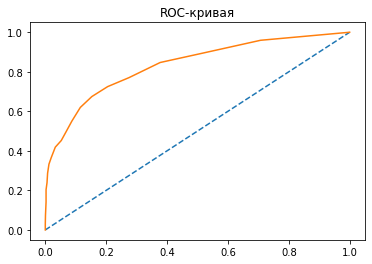

0.8336299820347329

In [38]:
fpr, tpr, thresholds = roc_curve(target_valid_ord, probabilities_one_valid)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid_ord, probabilities_one_valid)
auc_roc

## Тестирование модели

<div class="alert alert-info">
Наилучший результат f1 меры мы получили на модели случайного леса при n_estimators=25 и max_depth=7 при class_weight='balanced'</div

In [39]:
best_f1_forest

0.6335135135135135

In [43]:
best_depth_forest

7

<div class="alert alert-info">
Протестируем модель на тестовой выборке</div

In [42]:
print('balanced forest','f1:', best_f1_forest)

model = RandomForestClassifier(random_state=12345, n_estimators=best_est_balanced, max_depth=best_depth_forest, class_weight='balanced')
model.fit(features_test_ord, target_test_ord) 
predicted_test = model.predict(features_test_ord)
f1_test = f1_score(target_test_ord, predicted_test)
print ('тестирование модели:','f1:', f1_test)

balanced forest f1: 0.6335135135135135
тестирование модели: f1: 0.7626373626373626


<div class="alert alert-info">
Разница есть довольно ощутимая, f1 выше у тестовой модели</div

 ## Вывод

<div class="alert alert-info">
При загрузке данных было видно, что в столбце Tenure есть пропущенные значения. Это значения, указывающие, сколько лет человек является клиентом банка. Скорее всего, это новые клиенты, мы заменили их на медианное значение по столбцу.
<br>
Остальные столбцы корректные, типы данных нас устраивают.
<br>
Столбцы 'RowNumber','CustomerId', 'Surname' мы удалили, они не влияют на уход клиента из банка
    <br>
Столбцы Geography и Gender категориальные и требовали преобразования.
<br>
Наблюдается дизбаланс классов (примерно 80%:20%). Ушло клиентов намного меньше, чем осталось.
<br>
            <br>
Преобразовали категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding, OHE).
    <br>
Также подготовили данные, используя технику ordinal encoder (она понадобилась для модели дерева решений и случайного леса).
     <br>
Для моделирования исходные данные разделили на три выборки: обучающую (train) и валидационную (valid) и тестовую(test). 
    <br>
Объявили переменные:
    <br>
признаки: features_train, features_valid, features_test;
    <br>
целевой признак: target_train, target_valid, target_test.
    <br>
Затем все данные масштабировали
    <br>
 Сначала рассмотрели модели без учета дизбаланса классов. Для дерева решений и случайного леса будем брать выборки ord, для линейной регрессии - выборки ohe.
    <br>
        Исследовали дерево решений, подобрали гиперпараметры для лучшего значения метрики f1. Наилучший результат показал <b>max_depth</b> равное 4, <b>criterion</b> - 'gini'.
    <br>
  В модели случайного леса подобрали гиперпараметры <b>n_estimators</b> = 17 и <b>max_depth</b> = 15
    <br>
  В логистической регрессии - гиперпараметр <b>max_iter</b> = 10
    <br>
   Линейная регрессия показала не очень хороший результат.
    <br>

Наилучший результат f1-меры получился у случайного леса
    <br>
Попробовали бороться с дизбалансом классом с помощью гиперпараметра class_weight='balanced'
    <br>
Он очень помог, значение f1 и auc-roc стали больше, лучший результат у случайного леса
    <br>
Далее попробовали увеличение выборки upsample, алгоритм upsample поднял f1 меру.
<br>
Также нашли оптимальный threshold (порог) - 0.35
<br>
Построили roc-auc кривую
    <br>
    <br>
    Наилучший результат f1 меры мы получили на модели случайного леса при n_estimators=25 и <b>max_depth</b>=7  с параметром class_weight = 'balanced'
 Протестировали модель на тестовой выборке   
Разница есть довольно ощутимая, возможно, модель переобучена.
</div